In [25]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [26]:
img_size = (200, 200)
training_data = datasets.Flowers102(root="../flowerData", split="train", download=True, transform=transforms.Compose([transforms.Resize(img_size), ToTensor()]))
test_data = datasets.Flowers102(root="../flowerData", split="test", download=True, transform=transforms.Compose([transforms.Resize(img_size), ToTensor()]))

In [27]:
labels_map = {
    
}

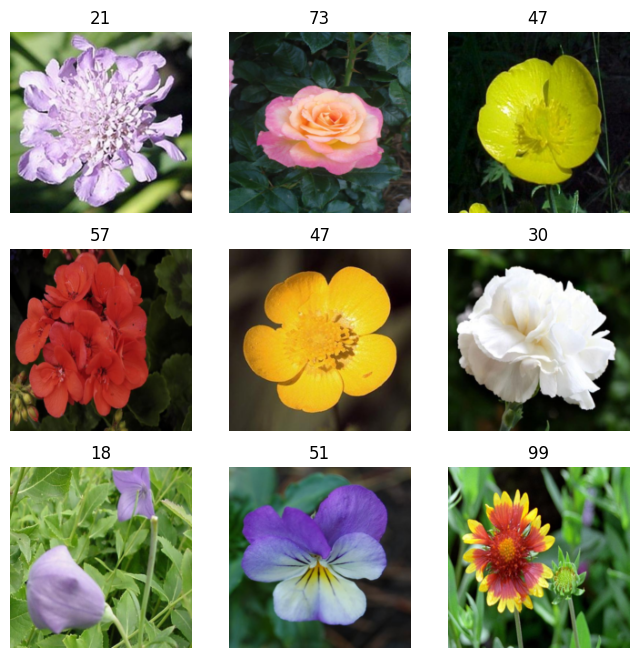

In [28]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*200*200, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 102)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [31]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120000, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=102, bias=True)
  )
)


In [32]:
def train_loop(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]")

In [33]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [34]:
learning_rate = 1e-3
batch_size = 64
epochs = 2
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.634603    [   64/ 1020]
Test Error: 
 Accuracy: 0.7%, Avg loss: 4.625429 

Epoch 2
-------------------------------
loss: 4.617001    [   64/ 1020]
Test Error: 
 Accuracy: 1.0%, Avg loss: 4.621431 

Epoch 3
-------------------------------
loss: 4.610674    [   64/ 1020]
Test Error: 
 Accuracy: 1.5%, Avg loss: 4.616767 

Epoch 4
-------------------------------
loss: 4.605194    [   64/ 1020]
Test Error: 
 Accuracy: 1.8%, Avg loss: 4.613388 

Epoch 5
-------------------------------
loss: 4.590210    [   64/ 1020]
Test Error: 
 Accuracy: 2.1%, Avg loss: 4.610086 

Done!
